# Study (false) detections around bright star masks
The radius of current HSC bright star masks, made by Andy Goulding, are selected by comparing the density of detections in increasingly large annuli around each bright stars with the average detection density. 

They are described in the paper of the Second Data Release of the Hyper Suprime-Cam Subaru Strategic Program (HSC-SSP, Aihara et al., 2019) and on this page: https://hsc-release.mtk.nao.ac.jp/doc/index.php/known-problems-2/#hsc-link-2
Note that detections and measurements are still performed inside the areas delimited by the masks, though a flag is set.

Still, one of the identified problems with the HSC Public Data Release 2 is that false detections sometimes occur around the edge of these masks. The aim of this notebook is thus to provide a plot of the number of detections as a function of increasing radius, around bright stars and beyond the edge of their mask.

## Options
The following two cells contain variables that the user might want to change to customize parameters related to the disgnostic (and resulting plot) generated.

The first one allows one to choose the path to the Butler repo we will read in, filter (note that while it determines which masks are read in*, the detections used are from merged catalog and will remain the same regardless), tracts, and binning options for the annuli.

The rerun in `/project/mschmitz/hscRerun/mynobg` is a subset of the 25 central patches in tract 9697, and had local background subtraction turned off.

Normally, we'd select bright objects to study from an outside catalog (Gaia). But for now, we are just reading in the actual mask region files, which means we have to jump through a few extra hoops.
If we want to look at whole tracts, we can just set `reselectBrightObjects` to `False`; if further selection of bright objects is needed, pass on a string.
The only one recognized at the moment is `boxAround`, where we pick a rectangular box around the detections closest to the edges of the considered sky region (because I only reran on the inner 25 patches of a tract for analysis sprint). This is admittedly hacky, but it's temporary, while we work with Andy's masks (and might prove useful anyway, eg to do this plot on the whole COSMOS field, that is circular).

\* not even that in the case of the Arcturus masks, that are all those from the I band despite the filenames containing a filter.

In [1]:
butlerPath = "/project/mschmitz/hscRerun/mynobg"

chosenFilter = "HSC-R" 
tractList = [9697] 
patchList = [["{},{}".format(i,j) for i in range(2,7) for j in range(2,7)]] * len(tractList)

# Annuli parameters
annSize = 5 # radius of each consecutive annulus, in arcsec
nbAnnuli = 20 # number of annuli

# which detections to keep
reselectBrightObjects = "boxAround" #False

# print a few checkpoints, validation plots, etc
verbose = False

# which mask to load - if False, loads Arcturus masks
gouldingMask = True

Change this cell if you want to save the end plot. If `savePlots` here is set to True, and a folder with the name given in `outputDir` does not exist, it will be created.

In [2]:
# whether to save plots and what to call them
savePlots = True
outputDir = 'plots/'
plotStub = "beyondMask"
plotExt = ".png"

The rest of the notebook should not require any changes before being ran (though note the cell that actually computes the number counts can take up to a few minutes per tract, depending on annuli parameters).

## Set up
Usual imports:

In [3]:
%matplotlib inline
import numpy as np
from lsst.daf.persistence import Butler
from lsst import geom
import matplotlib.pyplot as plt
import os

And script with utility functions:

In [4]:
import helperFuncs

Token to avoid rereading the detections every time, eg if we want to play with annuli parameters

In [5]:
src_loaded = False 

Initialize Butler repo:

In [6]:
butler = Butler(butlerPath)

Path to masks. Note there's likely some that are repeated when using Arcturus near the edges of patches.

In [7]:
if gouldingMask:
    # filenames have lower case filter in them:
    filterPrefix = "HSC-"
    if chosenFilter.startswith(filterPrefix) and len(chosenFilter[len(filterPrefix):]) == 1: 
        filter_lc = chosenFilter[len(filterPrefix):].lower() 
    else:
        raise RunTimeError(f"Filter name {chosenFilter} not recognized")
    print(filter_lc)
    mask_path = "/datasets/hsc/BrightObjectMasks/GouldingMasksS18A/new_S18Amask_{}.reg".format(
                                            filter_lc)
else:
    mask_path = "/datasets/hsc/BrightObjectMasks/ArcturusMasks/" 

r


If plots are to be saved, make sure the folder exists:

In [8]:
if savePlots:
    if not os.path.isdir(outputDir):
        os.makedirs(outputDir)

## Run
Warning: running cell below can take a while.

In [9]:
densities, brightMags, brightRads, brightCenters = [], [], [], []
for tract,patches in zip(tractList,patchList):
    # get sky map and WCS for this tract
    skymap = butler.get("deepCoadd_skyMap", tract=tract)
    tractInfo = skymap[tract]
    wcs = tractInfo.getWcs()
    
    # convert annuli parameters to pixel
    pixScale = geom.radToArcsec(wcs.getPixelScale())
    annSizePix = annSize / pixScale
    
    # load detection catalog for each patch
    if verbose:
        print("Loading and appending all detections...")
    if not src_loaded:
        src = butler.get('deepCoadd_meas', tract=tract, patch=patches[0], 
                         filter=chosenFilter)
        src = src[src['detect_isPatchInner']]
        for patch in patches[1:]:
            patchSrc = butler.get('deepCoadd_meas', tract=tract, patch=patch, 
                                 filter=chosenFilter)
            patchSrc = patchSrc[patchSrc['detect_isPatchInner']]
            src.extend(patchSrc)
            src_loaded = True
    if verbose:
        print(" > Done.")
        
    # set up bright object selector if needed
    if reselectBrightObjects:
        if reselectBrightObjects == "boxAround":
            if verbose:
                print("Computing box boundaries...")
            # hacky box for a rectangular subset of patches within a tract:
            x0 = np.min(src["base_SdssCentroid_x"])
            xWidth = np.max(src["base_SdssCentroid_x"]) - x0 
            y0 = np.min(src["base_SdssCentroid_y"]) 
            yWidth = np.max(src["base_SdssCentroid_y"]) - x0 
            selector = lambda brightCenters, brightMags, brightRadii : helperFuncs.boxSelector(
                        brightCenters, brightRadii, x0, y0, xWidth, yWidth,
                        extraBuffer = annSizePix*nbAnnuli)
            if verbose:
                print(" > Done.")
        else:
            raiseValueError("reselectBrightObjects {} not implemented".format(
                            reselectBrightObjects))
    else:
        selector = None
        
    # load bright star masks
    if gouldingMask:
        # if we want to read from the files with all the masks;
        # mask_path should then be absolute path to there
        brightCenters, mags, rads = helperFuncs.extractBrightStarInfo( 
                                              tractInfo, mask_path, verbose=verbose)
    else:
        # if we are reading Arcturus, we need to concatenate them for
        # all patches of interest first
        for j,patch in enumerate(patches):
            thismask = mask_path + '{}/BrightObjectMask-{}-{}-{}.reg'.format(
                                        tract, tract, patch, chosenFilter)
            bc, bm, br = helperFuncs.extractBrightStarInfo(tractInfo,
                                           thismask, verbose=verbose)
            brightCenters += bc
            if j:
                mags = np.hstack((mags, bm))
                rads = np.hstack((rads, br))
            else:
                mags = bm
                rads = br
    # and further select among these if needed                                                   
    if selector is not None:
        brightIdx = selector(brightCenters, mags, rads)
        brightCenters = [brightCenters[j] for j in brightIdx]
        mags = mags[brightIdx]
        rads = rads[brightIdx]

    # compute counts in annulii
    if verbose:
        print("Computing number counts around bright objects...")
    counts, areas = helperFuncs.countsBeyondMask(src, nbAnnuli, annSizePix, brightCenters,
                                           rads, verbose=verbose)
    if verbose:
        print(" > Done.")
    # normalize by annulus area
    dens = counts / areas
    densities += [dens]
    brightMags += [mags]
    brightRads += [rads]

## Plot!

Compute distance to edge of each inner radius:

In [10]:
distanceToEdge = np.arange(0, annSize*nbAnnuli, annSize)

Plot a few individual objects first just to check:

In [11]:
if verbose:
    for dens, mags, rads, in zip(densities, brightMags, brightRads):
        for starIdx in np.argsort(mags)[::199]:
            brst = dens[starIdx]
            plt.plot(distanceToEdge, brst)
            plt.xlabel('Distance to mask edge (arcsec)')
            plt.ylabel(r'Detection density (arcsec$^{-2}$)')
            plt.title('mag:{}'.format(mags[starIdx]))
            plt.show()
            plt.close()

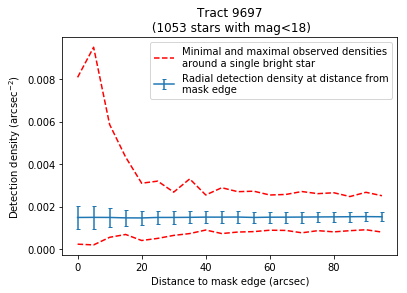

In [12]:
for tract, dens in zip(tractList, densities):
    # average detection densities around stars in this magnitude bin:
    magDen = np.mean(dens,axis=0)
    magDenStd = np.std(dens,axis=0)
    plt.errorbar(distanceToEdge, magDen, yerr=magDenStd, capsize=2, 
                 label='''Radial detection density at distance from
mask edge''')
    plt.plot(distanceToEdge, np.min(dens,axis=0), c='red', ls='--', 
             label='''Minimal and maximal observed densities
around a single bright star''')
    plt.plot(distanceToEdge, np.max(dens,axis=0), c='red', ls='--')

    plt.title("Tract {}\n".format(tract)+" ({} stars with mag<18)".format(len(dens)))
    plt.xlabel('Distance to mask edge (arcsec)')
    plt.ylabel(r'Detection density (arcsec$^{-2}$)')
    plt.legend()
    
    if savePlots:
        plt.savefig(outputDir + plotStub + "tract{}".format(tract) + plotExt)
    plt.show()
    plt.close()

## Conclusion/discussion
The plot above shows no extra detections beyond the current bright star masks' edges. The same conclusion can be drawn from those in `RadiusDensity.ipynb`.

We initially chose to look into detection density around bright stars for the February 2020 analysis sprint in great part because of the right-most plot in [this section of the "Known Problems" page of HSC DR2](https://hsc-release.mtk.nao.ac.jp/doc/index.php/known-problems-2/#hsc-link-2). We expected to see an overdensity of detections right around the edge of the masks. 

Another reason we wanted to have this plot handy in the future is so we could use it to test our upcoming extended PSF model: this overdensity should disappear when detection is ran after subtracting the bright star halos using a fitted extended PSF.

After running on a run of the pipeline in its default configuration (which can be done by changing the `butlerPath` variable in the first code cell above), we found no such overdensity. An initial guess was that the local background subtraction hid this effect by (partly) subtracting the bright stars' halos; which led to the rerun in `/project/mschmitz/hscRerun/mynobg`, with local background subtraction turned off, and the above plot. Again, no bump on the left-hand side.

In hindsight, however, it makes sense that even with no local background subtraction, no overdensity is apparent here. By construction, the radius of the Goulding masks is chosen so that the median number of detections beyond them is no larger than 3$\sigma$ above "background" (i.e., far from any and all bright object) levels.

It is still unclear to me how the plot on the Known Problem page was made, though note it is on one of the narrow bands. The `KnownProblemPlotsOnDisplay.ipynb` notebook, in this folder, tries to reproduce the plot for any tract, filter, and mask file - and I could find no such overdensities beyond the masks.

(Note I wondered whether those objects with extremely high detection densities right beyond the mask, as shown by the upper red dashed line above, were especially red bright stars - but no, they are just junk).

On the bright star mask front, therefore, the conclusion is simply that this plot is just not the one we want; we should look at the quality of the photometry of objects around bright stars, not at how many of them there are.

The plot can still be used, however, if and when we move back to smaller mask sizes, for instance thanks to an extended PSF model (and the subtraction of bright stars it allows for). Indeed, at present, clear overdensities can be seen if we "pretend" the masks are smaller than they are, say, by a factor of about six:

<img src="plots/wrongrad_beyondMasktract9697.png" style="width: 400px;">

If the subtraction of bright star halos is successful, this bump should disappear (as long as it's far enough to be caused by the wings of the star and not ghosts).